正在进行K-Means聚类 (对所有像素)...
正在进行高精度谱聚类 (这会花费一些时间)...


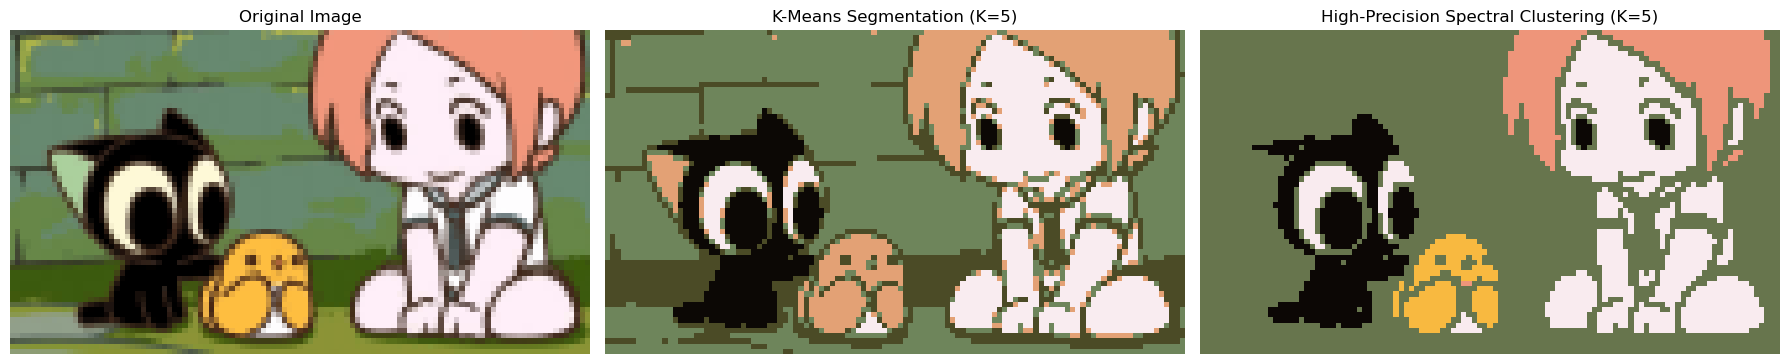

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# --- 1. 读取并预处理图像 ---
image_path = 'image_smaller.png'
original_image_bgr = cv2.imread(image_path)
original_image_rgb = cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2RGB)

# 转换为浮点数并归一化
image_float = np.array(original_image_rgb, dtype=np.float64) / 255

h, w, d = image_float.shape
pixel_list_rgb = image_float.reshape((h * w, d))

# --- 高精度修改点 3 (可选): 转换到LAB颜色空间 ---
# print("Converting to LAB color space...")
# lab_image = cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2LAB)
# pixel_list_lab = lab_image.reshape((h * w, d))
# scaler = StandardScaler()
# pixel_data_to_cluster = scaler.fit_transform(pixel_list_lab)


# --- 为了对比，我们先使用RGB空间 ---
pixel_data_to_cluster = pixel_list_rgb # 直接使用归一化的RGB值

# --- 2. 应用聚类算法 ---
n_clusters = 5

# K-Means作为基准对比
print("正在进行K-Means聚类 (对所有像素)...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(pixel_data_to_cluster)

# --- 高精度修改点 1 & 2: 对所有像素使用RBF核的谱聚类 ---
print("正在进行高精度谱聚类 (这会花费一些时间)...")
gamma_value = 50 # 这是一个关键超参数，可以调整
spectral = SpectralClustering(n_clusters=n_clusters, random_state=42,
                              affinity='rbf', 
                              gamma=gamma_value,
                              n_jobs=-1) # 使用所有CPU核心

# fit_predict现在作用于所有像素
spectral_labels = spectral.fit_predict(pixel_data_to_cluster)


# --- 3. 生成分割后的图像 ---
def recreate_image(labels, codebook, h, w):
    image = np.zeros((h, w, codebook.shape[1]))
    labels_2d = labels.reshape(h, w)
    for i in range(h):
        for j in range(w):
            image[i, j] = codebook[labels_2d[i, j]]
    return image

# K-Means的颜色码本
kmeans_image = recreate_image(kmeans_labels, kmeans.cluster_centers_, h, w)

# 谱聚类的颜色码本 (用每个簇的平均颜色填充)
spectral_codebook = np.zeros((n_clusters, d))
for i in range(n_clusters):
    # 注意：这里我们用原始的RGB像素列表来计算平均颜色
    spectral_codebook[i] = pixel_list_rgb[spectral_labels == i].mean(axis=0)
spectral_image = recreate_image(spectral_labels, spectral_codebook, h, w)

# --- 4. 可视化对比结果 ---
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(kmeans_image)
plt.title(f'K-Means Segmentation (K={n_clusters})')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(spectral_image)
plt.title(f'High-Precision Spectral Clustering (K={n_clusters})')
plt.axis('off')

plt.tight_layout()
plt.show()

**上述代码K-means的效果看起来还要好一点**

这是一个**极好**的、**极其深刻**的观察，揭示了所有机器学习算法的一个核心真理：**理论上“更强大”的算法，在实践中并不总是“更好”的**。

K-Means在您的图片上看起来效果更好，这背后有几个非常重要的原因。让我们深入剖析一下。

---

### 1. 问题的本质：我们真正在做什么？

我们解决的“图像分割”问题，实际上可以被更精确地定义为**“颜色量化 (Color Quantization)”**。

*   **我们的目标**：找到图中最具代表性的 `K` 种颜色（一个“调色板”），然后用这个调色板里的颜色来重新绘制整张图片。
*   **在颜色空间中**：这意味着我们要在一个三维的RGB空间中，找到 `K` 个**最密集的颜色“云团”**。比如，“天空”的所有蓝色像素会在RGB空间中形成一个紧凑的、偏向蓝色的点云；“草地”的所有绿色像素会形成另一个点云。

**K-Means恰好是这个任务的“天选之子”**。K-Means的**唯一目标**就是找到 `K` 个**簇的中心点 (Centroids)**，并最小化所有点到其中心点的距离之和。这在我们的问题中，完美地等同于：**找到 `K` 个最具代表性的平均颜色，并用它们来代表所有像素。**

K-Means在这里不是在寻找复杂的几何形状，它是在**提取主色调**，而这个任务的本质就是寻找球状的、密集的颜色簇。

### 2. 谱聚类的“超能力”被浪费了

谱聚类的核心优势在于它能够识别**形状极其不规则**的簇，因为它关心的是点与点之间的**连通性 (Connectivity)**，而不是它们与某个中心点的距离。

*   **谱聚类的用武之地**：想象一下数据是两个嵌套的月牙形。K-Means会无情地从中间将它们切开，而谱聚类能完美地识别出这两个独立的、弯曲的结构。

*   **在我们的颜色空间里发生了什么？** “天空蓝”这个颜色簇和“草地绿”这个颜色簇之间，**并不存在**一个由“蓝绿色”像素构成的“桥梁”将它们连接成一个复杂的形状。它们就是两个**相互分离、各自紧凑**的云团。

**因此，谱聚类的“识别复杂形状”的超能力在这里完全没有用武之地。** 它就像你派了一个能飞檐走壁的忍者去参加百米赛跑，他很强大，但他的核心技能在这里并不适用。

### 3. 谱聚类的“致命软肋”：超参数敏感性

这是导致您看到糟糕结果的**最直接、最技术性**的原因。谱聚类，特别是使用`rbf`核时，对 `gamma` 这个参数**极其敏感**。

`similarity = exp(-gamma * ||pixel_a - pixel_b||²)`

*   **如果 `gamma` 设置得太大** (比如我们设的`50`对于您的图片可能太大了)：
    *   `exp()` 函数的指数部分会变成一个很大的负数。
    *   这导致只有颜色**几乎完全一样**的像素点才会被认为有一点点相似性，其他所有点的相似度都趋近于0。
    *   结果就是，算法构建的关系图变成了一堆**孤立的点和极小的团块**。在这样的图上进行分割，结果往往是混乱和无意义的，因为它找不到大的、连通的结构。

*   **如果 `gamma` 设置得太小**：
    *   指数部分总是一个很小的负数，接近于0。
    *   `exp()` 的结果总是接近于1。
    *   这意味着**所有颜色**的像素点都被认为是高度相似的。
    *   结果就是，算法认为整张图片是一个不可分割的整体，可能会把所有像素都归为一类。

**K-Means没有这个问题**。它没有像`gamma`这样敏感且难以调试的参数。它的工作方式更“鲁棒”，只要数据确实有几个密度中心，它总能找到一个合理的结果。

### 结论：何时该用谁？

这次的实验给了我们一个宝贵的教训，让我们重新定义“最优”算法：

1.  **对于颜色量化 (Color Quantization) 任务：**
    *   **目标**：提取图片中的 `K` 个主色调，简化颜色。
    *   **最佳算法**：**K-Means**。它快速、简单、鲁棒，并且其内在机制与任务目标完美契合。

2.  **对于真正的图像分割 (Image Segmentation) 任务：**
    *   **目标**：将图片分割成**语义上**有意义的区域（比如，把一只猫从背景中分割出来）。
    *   **谱聚类的正确用法**：在这种情况下，我们不能只考虑颜色！相似度矩阵的构建需要同时考虑**颜色相似度**和**空间邻近性 (Spatial Proximity)**。
        *   即，两个像素点只有在**颜色相近** **并且** 在**图片上的位置也很近**时，才被认为是高度相似的。
        *   通过这种方式构建图，谱聚类就能发挥其强大威力，找到那些“颜色相近且连成一片”的区域，从而完美地分割出猫的轮廓。但这需要更复杂的代码来实现。

**总结一下：**
您看到K-Means效果更好，是因为我们给出的问题，本质上是一个**K-Means的“主场”**。而我们强行让谱聚类上场，不仅它的优势无法发挥，它对参数的敏感性这个缺点反而被放大了，导致了糟糕的结果。这充分说明了，**深刻理解问题本质和算法的适用边界，远比追求理论上“更高级”的算法要重要得多。**